# Self-Driving Car Engineer Nanodegree

## Project: **Finding Lane Lines on the Road** 

## Import all Required Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import math

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

## Helper Functions

In [2]:

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    if lines is not None:
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
        
    return line_img, lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

#auto_threshold canny
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
 
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
 
    # return the edged image
    return edged

def calc_line_reg(lines):
    
    #create lists for the relevant points of the left and right lange
    xpointsL=[]
    xpointsR=[]
    ypointsL=[]
    ypointsR=[]
    
    #create lists for the slope and intercept coefficients of the lanes
    mL=[]
    mR=[]
    bL=[]
    bR=[]
    
    #parse all lines
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x2-x1>0: #intercept 0 denominator
                
                #calculate the slope
                m=(y2-y1)/(x2-x1)
                
                if m>0: #if m>0 --> right lane
                    
                    #append lists
                    xpointsR.append(x1)
                    xpointsR.append(x2)
                    ypointsR.append(y1)
                    ypointsR.append(y2)
                    
                    mR.append(m)
                    bR.append(y1-m*x1) #calc intercept
                    
                if m<0: #if m<0 --> left lane
                    
                    #append lists
                    xpointsL.append(x1)
                    xpointsL.append(x2)
                    ypointsL.append(y1)
                    ypointsL.append(y2)
                    
                    mL.append(m)
                    bL.append(y1-m*x1) #calc intercept
            else:
                print("Division by zero")
                    
                    
    #execute polyfit of 1st order for the left lane
    xL = np.array(xpointsL)
    yL = np.array(ypointsL)
    if len(xL)>0 and len(yL)>0:  
        zL = np.polyfit(xL, yL, 1)
    else:
        zL = [np.nan, np.nan] #if not sucessful return NaN
    
    #execute polyfit of 1st order for the right lane
    xR = np.array(xpointsR)
    yR = np.array(ypointsR)
    if len(xR)>0 and len(yR)>0:  
        zR = np.polyfit(xR, yR, 1)
    else:
        zR = [np.nan, np.nan] #if not sucessful return NaN
        
    #calculate median values for the slope and intercept
    m_median_R=np.median(mR)
    m_median_L=np.median(mL)
    
    b_median_R=np.median(bR)
    b_median_L=np.median(bL)
    
    return zL, zR, m_median_L, m_median_R, b_median_L, b_median_R


## Building a Lane Finding Pipeline (step by step)

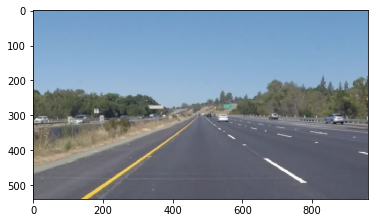

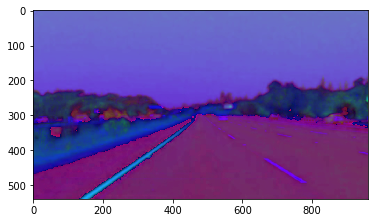

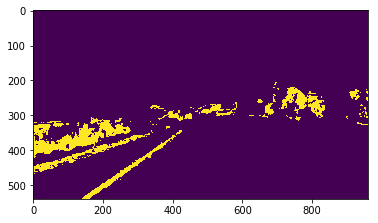

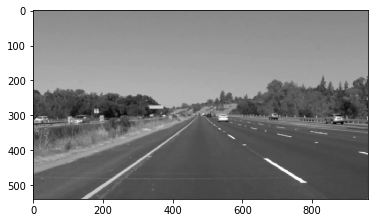

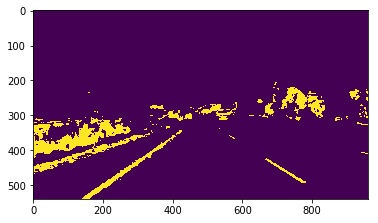

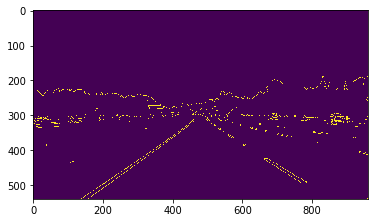

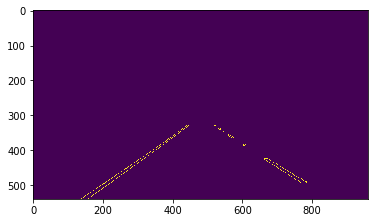

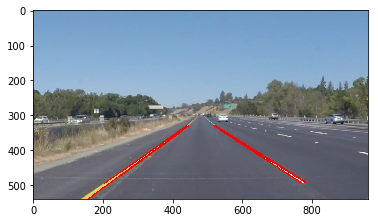

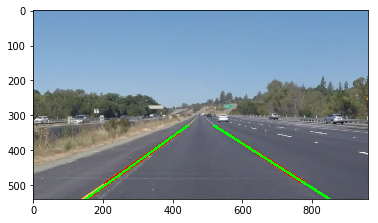

In [3]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
img_path="test_images/"+os.listdir("test_images/")[0]
image = mpimg.imread(img_path)

#gaussian smoothing
gauss=gaussian_blur(image, 5)
plt.figure()
plt.imshow(gauss)
    
#0th step, convert to HSV since it is better to detect certain colors like the yellow lane
hsv = cv2.cvtColor(gauss, cv2.COLOR_RGB2HSV)
plt.figure()
plt.imshow(hsv)
    
low_y = np.array([20, 0, 100]) #upper HSV for yellow
high_y = np.array([30, 255, 255]) #lower HSV for yellow
yellow_hsv = cv2.inRange(hsv, low_y, high_y) #create mask
plt.figure()
plt.imshow(yellow_hsv)
    
#1st step, create gray scale image
gray = grayscale(gauss)
white_gray = cv2.inRange(gray, 190, 255) #create mask for white in image
plt.figure()
plt.imshow(gray, cmap='gray')

#2nd step, combine yellow HSV mask and white grayscale mask
img_y_white = cv2.bitwise_or(white_gray, yellow_hsv)
plt.figure()
plt.imshow(img_y_white)
    
#3rd step, canny detection, low and high thresholds could be improved
edges=auto_canny(gray, 0.1)
plt.figure()
plt.imshow(edges)
    
#4rd step, mask Region of intrest by a trapezoid
mask = np.zeros_like(edges)   
ignore_mask_color = 255   
imshape = image.shape
vertices = np.array([ [(0,imshape[0]),((imshape[1]/2)-50, (imshape[0]/2)+60), ((imshape[1]/2)+50, (imshape[0]/2)+60), (imshape[1],imshape[0])] ], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)
plt.figure()
plt.imshow(masked_edges)
    
#5th step, execute hough transform
rho = 1 
theta = np.pi/180
threshold = 5
min_line_len = 150
max_line_gap = 150
hough=hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap) #function also return the lines

#6th step, visualize detected lines in RED
draw_lines(image, hough[1]) #uncomment for debug purposes
plt.figure()
plt.imshow(image)
    
####################
#7th step, condense lines to two lines for the left and right lane
    
lines = hough[1] #store all lines
    
if lines is not None: #if there are lines detected at all
    
    #return polyfit results for left and right lane as well as medians of slope and intercept evaluation
    zL, zR, m_median_L, m_median_R, b_median_L, b_median_R = calc_line_reg(lines) 
            
    mask_y_car=int(image.shape[0]) # Y value of the lower limit of the ROI (here 540px)
    mask_y_horizont=int(vertices[0][1][1]) #Y value of the upper limit of the ROI (here 330px)
    
    #Left lane line processing
    if not math.isnan(zL[1]) and not math.isnan(zL[0]): #only execute if there was a sucessful polyfit of this image
        
        #calculate the required points for the line according to the limits of the ROI
        x1=int((mask_y_car-zL[1])/zL[0])
        x2=int((mask_y_horizont-zL[1])/zL[0])
        y1=mask_y_car
        y2=mask_y_horizont
        cv2.line(image, (x1, y1), (x2, y2), color=[0, 255, 0], thickness=5)
    
    #Right lane line processing same as above
    if not math.isnan(zR[1]) and not math.isnan(zR[0]):
    
        x1=int((mask_y_car-zR[1])/zR[0])
        x2=int((mask_y_horizont-zR[1])/zR[0])
        y1=mask_y_car
        y2=mask_y_horizont
        cv2.line(image, (x1, y1), (x2, y2), color=[0, 255, 0], thickness=5)

plt.figure()
plt.imshow(image) #output final image

## Define workflow function

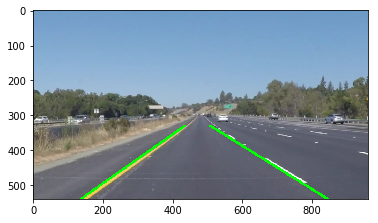

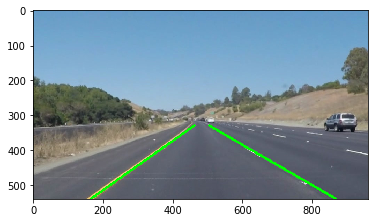

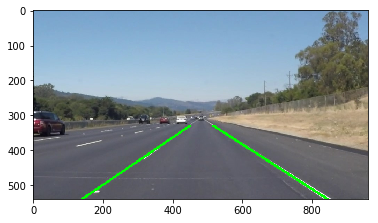

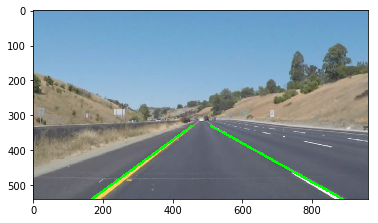

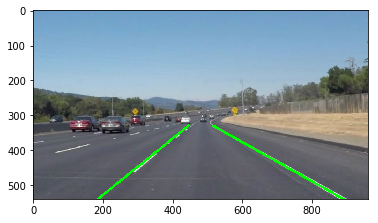

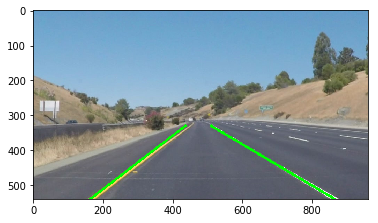

In [4]:
#define function to execute complete workflow
def workflow(image):
    
    #make global variables available in function
    global zL_buff
    global zR_buff
    global C
    
    #gaussian smoothing
    gauss=gaussian_blur(image, 5)

    #0th step, convert to HSV since it is better to detect certain colors like the yellow lane
    hsv = cv2.cvtColor(gauss, cv2.COLOR_RGB2HSV)

    low_y = np.array([20, 0, 100]) #upper HSV for yellow
    high_y = np.array([30, 255, 255]) #lower HSV for yellow
    yellow_hsv = cv2.inRange(hsv, low_y, high_y) #create mask

    #1st step, create gray scale image
    gray = grayscale(gauss)
    white_gray = cv2.inRange(gray, 210, 255) #create mask for white in image

    #2nd step, combine yellow HSV mask and white grayscale mask
    img_y_white = cv2.bitwise_or(white_gray, yellow_hsv)

    #3rd step, canny detection, low and high thresholds could be improved
    edges=auto_canny(img_y_white, 0.6)

    #4rd step, mask Region of intrest by a trapezoid
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   
    imshape = image.shape
    vertices = np.array([ [(0,imshape[0]),((imshape[1]/2)-50, (imshape[0]/2)+60), ((imshape[1]/2)+50, (imshape[0]/2)+60), (imshape[1],imshape[0])] ], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)

    #5th step, execute hough transform
    rho = 1 
    theta = np.pi/180
    threshold = 5
    min_line_len = 50
    max_line_gap = 100
    hough=hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap) #function also return the lines

    #6th step, visualize detected lines in RED
    #draw_lines(image, hough[1]) #uncomment for debug purposes

    ####################
    #7th step, condense lines to two lines for the left and right lane
    
    lines = hough[1] #store all lines
    
    mask_y_car=int(image.shape[0]) # Y value of the lower limit of the ROI (here 540px)
    mask_y_horizont=int(vertices[0][1][1]) #Y value of the upper limit of the ROI (here 330px)
    
    if lines is not None: #if there are lines detected at all
        
        #return polyfit results for left and right lane as well as medians of slope and intercept evaluation
        zL, zR, m_median_L, m_median_R, b_median_L, b_median_R = calc_line_reg(lines) 
        
        #uncomment this to use medians of slope and intercept for processing
        zL[0]=m_median_L
        zL[1]=b_median_L
        zR[0]=m_median_R
        zR[1]=b_median_R
            
        #Left lane line processing
        if not math.isnan(zL[1]) and not math.isnan(zL[0]): #only execute if there was a sucessful polyfit of this image
            
            # in the first run set the buffer values to the current values
            if zL_buff[0]==0: 
                zL_buff[0]=zL[0] #slope
            else:
                #the new values is filtered and damped by the buffered value by the coefficient C
                zL[0]=C*zL_buff[0]+(1-C)*zL[0]
                
                #update the buffered values
                zL_buff[0]=zL[0]
                
            if zL_buff[1]==0: 
                zL_buff[1]=zL[1] #intercept
            else:
                #same for the intercept
                zL[1]=C*zL_buff[1]+(1-C)*zL[1]
                
                zL_buff[1]=zL[1]
        
        else: #if there was no sucessful polyfit take buffered values
            zL[0]=zL_buff[0] #slope
            zL[1]=zL_buff[1] #intercept
    
        #calculate the required points for the line according to the limits of the ROI
        x1=int((mask_y_car-zL[1])/zL[0])
        x2=int((mask_y_horizont-zL[1])/zL[0])
        y1=mask_y_car
        y2=mask_y_horizont
        cv2.line(image, (x1, y1), (x2, y2), color=[0, 255, 0], thickness=5)
    
        #Right lane line processing same as above
        if not math.isnan(zR[1]) and not math.isnan(zR[0]):
        
            # in the first run set the buffer values to the current values
            if zR_buff[0]==0: 
                zR_buff[0]=zR[0] #slope
            else:
                #the new values is filtered and damped by the buffered value by the coefficient C
                zR[0]=C*zR_buff[0]+(1-C)*zR[0]
                
                #update the buffered values
                zR_buff[0]=zR[0]
                
            if zR_buff[1]==0: 
                zR_buff[1]=zR[1] #intercept
            else:
                #same for the intercept
                zR[1]=C*zR_buff[1]+(1-C)*zR[1]
                
                zR_buff[1]=zR[1]
        
        else: #take buffered values
            zR[0]=zR_buff[0]
            zR[1]=zR_buff[1]
    
        x1=int((mask_y_car-zR[1])/zR[0])
        x2=int((mask_y_horizont-zR[1])/zR[0])
        y1=mask_y_car
        y2=mask_y_horizont
        cv2.line(image, (x1, y1), (x2, y2), color=[0, 255, 0], thickness=5)
    
        #annotate the image with the two remaining lines for the left and right lane
        result=weighted_img(image, hough[0])
    else:
        result=image
    
    return result


#Test workflow for a series of singles images
#Slight offsets are due to the filtering that is mostly required for video processing

#introduce global variables for buffering
zL_buff=[0, 0]
zR_buff=[0, 0]

#Filter coefficient for smoothing
C=0.9

#read all images
img_file_names=os.listdir("test_images/")

#process all test images
for i in range(0,len(img_file_names)):
    image = mpimg.imread("test_images/"+img_file_names[i])
    plt.figure()
    processed=workflow(image)
    plt.imshow(processed)
    zL_buff=[0, 0]
    zR_buff=[0, 0]
    cv2.imwrite("test_images_output/output_"+img_file_names[i],processed) #imsave somehow not working

# Test on Videos

In [5]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result=workflow(image)

    return result

In [6]:
#reset global variables for buffering
zL_buff=[0, 0]
zR_buff=[0, 0]

white_output = 'test_videos_output/solidWhiteRight.mp4'
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:05<00:00, 39.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 13.1 s, sys: 56 ms, total: 13.2 s
Wall time: 5.95 s


In [7]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [8]:
#reset global variables for buffering
zL_buff=[0, 0]
zR_buff=[0, 0]

yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:16<00:00, 42.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 39.5 s, sys: 392 ms, total: 39.9 s
Wall time: 17.3 s


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

In [10]:
#reset global variables for buffering
zL_buff=[0, 0]
zR_buff=[0, 0]

challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


 11%|█         | 27/251 [00:00<00:06, 36.95it/s]

Division by zero


 18%|█▊        | 45/251 [00:01<00:06, 32.35it/s]

Division by zero


100%|██████████| 251/251 [00:10<00:00, 23.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 19.9 s, sys: 244 ms, total: 20.1 s
Wall time: 11.1 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))